### Implementation of the Paper ["A Single Backlit Image Enhancement Method For Improvement Of Visibility Of Dark Part"](https://ieeexplore.ieee.org/document/9506526) by M. Akai _et al._


### Imports


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
from scipy.signal import convolve2d
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
from drive.MyDrive.Projects.Backlit_Image_Enhancement.niqe_master.niqe import niqe

In [ ]:
def read_ppm(filename):
    with open(filename, 'rb') as f:
        # Read magic number (P3 or P6)
        magic_number = f.readline().strip()
        while True:
            line = f.readline()
            if line.startswith(b'#'):
                continue
            else:
                break

        # Read width and height
        width, height = map(int, line.strip().split())

        # Read maximum gray value (usually 255)
        max_gray = int(f.readline().strip())

        # Read pixel data
        if magic_number == b'P3':
            # ASCII format
            rpix = []
            gpix = []
            bpix = []
            data = f.read().split()
            for i in range(height):
                rrow = [int(data[(i * 3*width + j)]) for j in range(0,3*width,3)]
                rpix.append(rrow)
                grow = [int(data[(i * 3*width + j)]) for j in range(1,3*width,3)]
                gpix.append(grow)
                brow = [int(data[(i * 3*width + j)]) for j in range(2,3*width,3)]
                bpix.append(brow)
        elif magic_number == b'P6':
            # Binary format
            pixel_data = f.read()
            rpix = []
            gpix = []
            bpix = []
            for i in range(height):
                rrow = [pixel_data[(i * 3*width + j)] for j in range(0,3*width,3)]
                rpix.append(rrow)
                grow = [pixel_data[(i * 3*width + j)] for j in range(1,3*width,3)]
                gpix.append(grow)
                brow = [pixel_data[(i * 3*width + j)] for j in range(2,3*width,3)]
                bpix.append(brow)

        else:
            raise ValueError('Unsupported PGM format: ' + magic_number.decode())
        rgb = np.stack([rpix,gpix,bpix],axis=-1)
        return rgb, width, height, max_gray, magic_number


In [ ]:
input_file="/content/drive/MyDrive/Projects/Backlit_Image_Enhancement/fig1.ppm"

In [ ]:
RGB, width, height, max_gray, magic_number = read_ppm(input_file)

print(f"Width: {width}, Height: {height}, Max Gray: {max_gray}, Format: {magic_number}")
print("First row of pixels:", RGB[0][:10],"\n",RGB.shape)

Width: 1132, Height: 850, Max Gray: 255, Format: b'P6'
First row of pixels: [[132 143 145]
 [132 143 145]
 [132 143 145]
 [132 143 145]
 [133 144 146]
 [133 144 146]
 [133 143 147]
 [133 143 147]
 [133 143 147]
 [133 144 146]] 
 (850, 1132, 3)


#### Hyperparameters

- **GAMMA:** 2
- **ALPHA:** 0.7
- **EPSILON:** 1e-7


In [ ]:
parameters = {
    "GAMMA": 2,
    "ALPHA": 0.7,
    "EPSILON": 1e-7
}

(np.float64(-0.5), np.float64(1131.5), np.float64(849.5), np.float64(-0.5))

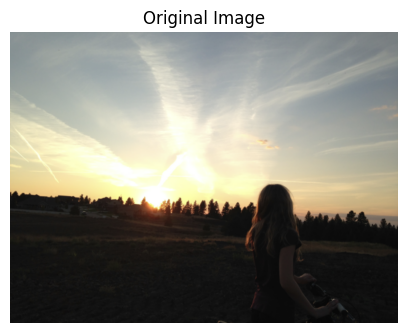

In [ ]:
plt.figure(figsize=(5, 5))
plt.imshow(RGB)
plt.title("Original Image")
plt.axis("off")


#### Grayscale Image (by taking mean of all channels)


In [ ]:
img_grayscale = np.mean(RGB.astype(np.float32), axis=2)

img_grayscale.shape

(850, 1132)

In [ ]:
def plot_intensity_histogram(image, title=None):
    if len(image.shape) != 2:
        print("[ERROR]: Image must be grayscale image with only 2 dimensions.")
        return

    figure, (hist_ax, image_ax) = plt.subplots(1, 2, figsize=[12, 4])

    image = image.astype(np.uint8)
    image_flattened = image.flatten()
    _ = hist_ax.hist(image_flattened, bins="auto")

    hist_ax.set_xlabel("Intensity")
    hist_ax.set_ylabel("Frequency")
    hist_ax.set_title(f"{title} - Intensity Histogram")

    image_ax.set_title(f"{title} - Image")
    image_ax.imshow(image, cmap="gray")
    plt.axis("off")

    plt.show()

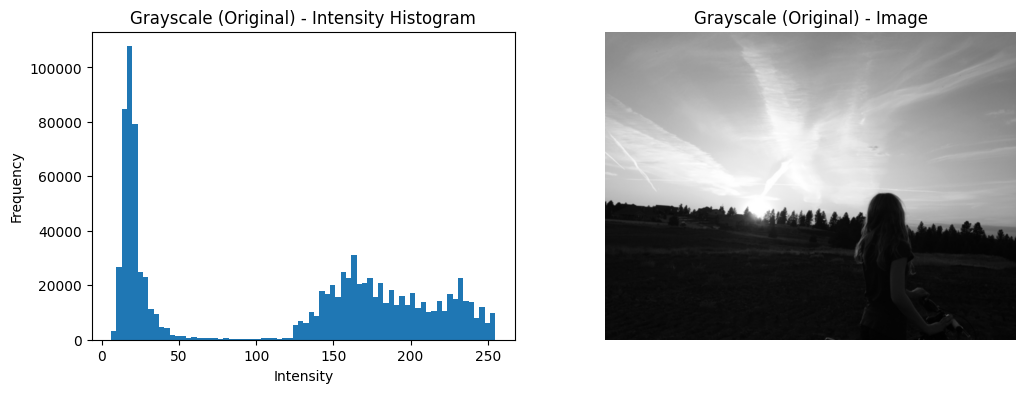

In [ ]:
plot_intensity_histogram(img_grayscale, "Grayscale (Original)")

#### Gamma Correction


In [ ]:
gamma = parameters["GAMMA"]
img_gamma = 255.0 * (img_grayscale / 255.0) ** (1.0 / gamma)

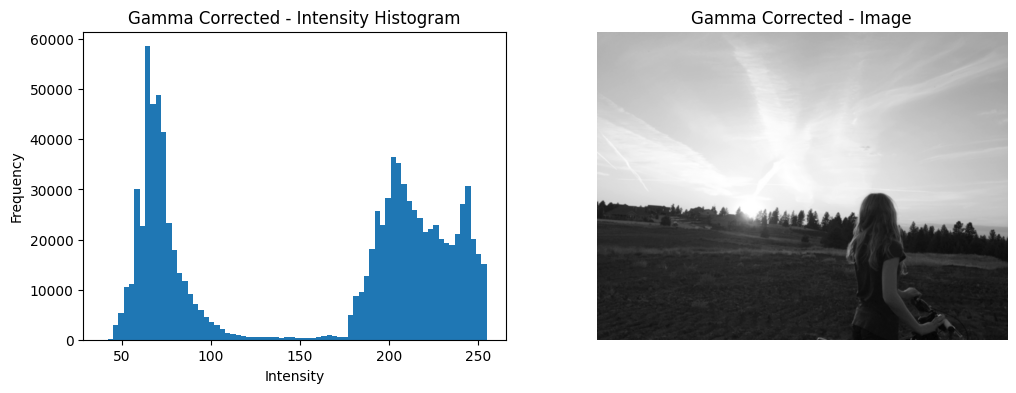

In [ ]:
plot_intensity_histogram(img_gamma, "Gamma Corrected")

#### Histogram Equalization


In [ ]:
def image_histogram_equalization(image):
    # get image histogram
    image_histogram, bins = np.histogram(image.astype(np.uint8).flatten(), 256, density=True)
    cdf = image_histogram.cumsum()
    cdf = 255 * cdf / cdf[-1]

    # linear interpolation
    image_equalized = np.interp(image.flatten(), bins[:-1], cdf)

    return image_equalized.reshape(image.shape)

In [ ]:
img_he = image_histogram_equalization(img_grayscale)

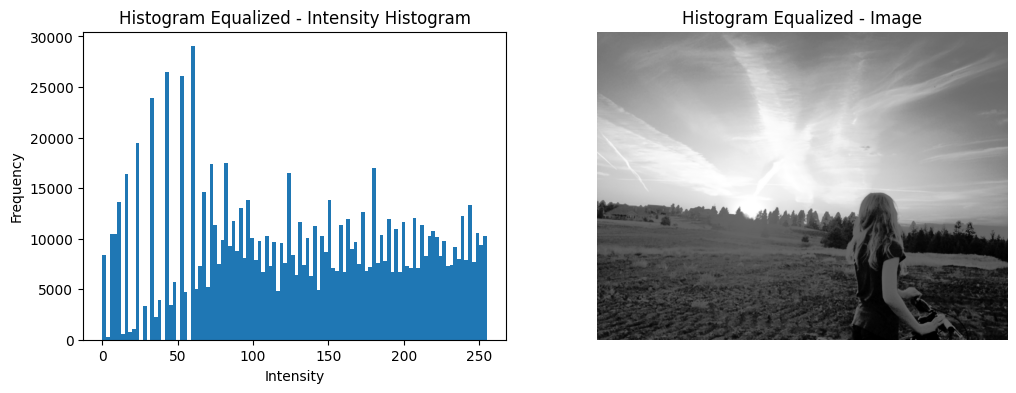

In [ ]:
plot_intensity_histogram(img_he, "Histogram Equalized")

#### Alpha Bending of the Gamma Corrected and Histogram equalized images.


In [ ]:
alpha = parameters["ALPHA"]
img_alpha_bent = (1.0 - alpha) * img_gamma + alpha * img_he

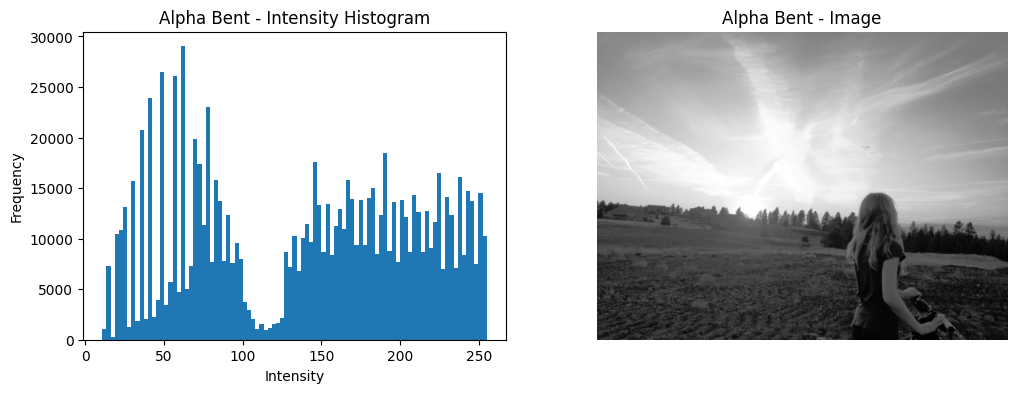

In [ ]:
plot_intensity_histogram(img_alpha_bent, "Alpha Bent")

#### Obtaining the ideal threshold value which maximizes the optimization function:

$$ω_bω_w(m_b - m_w)^2$$

_here:_

- $ω_b$: Number of pixels belonging to **black** class.
- $ω_w$: Number of pixels belonging to **white** class.
- $m_b$: Mean of pixels belonging to **black** class.
- $m_w$: Mean of pixels belonging to **white** class.

##### Obtaining binary weight map:

$$
\begin{equation*}
    W_{ij} =
    \begin{cases}
        1 & I_{ij} < t, \\
        0 & otherwise
    \end{cases}
\end{equation*}
$$


In [ ]:
def get_threshold_and_binary_weight_map(image):
    def objective_fnc(image_flat, threshold):
        condition = image_flat < threshold
        a = image_flat[condition]
        b = image_flat[~condition]
        if a.shape[0] == 0 or b.shape[0] == 0:
            return 0.0
        return a.shape[0] * b.shape[0] * (np.mean(a) - np.mean(b)) ** 2

    image_flat = image.flatten()
    objective_values = [objective_fnc(image_flat, t) for t in range(256)]

    best_t = np.argmax(objective_values)

    return best_t, np.where(image < best_t, 1.0, 0.0)

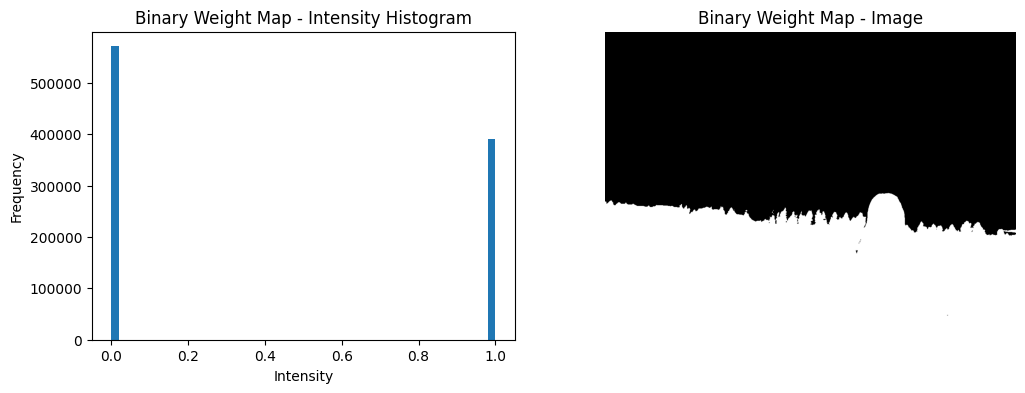

In [ ]:
threshold, W = get_threshold_and_binary_weight_map(img_grayscale)

plot_intensity_histogram(W, "Binary Weight Map")

#### Obtaining the weight map using the grayscale image and binary weight map:

$$
\begin{split}
    \tilde{W} &= \overline{a} \otimes \overline{{I^{nor}}} + \overline{b} \\
    a = (\overline{I^{nor} \otimes W} &- \overline{I^{nor}} \otimes \overline{W}) \oslash(\overline{I^{nor} \otimes I^{nor}} - \overline{I^{nor}}^2 + ϵ) \\
    b &= \overline{W} - a \otimes \overline{I^{nor}}
\end{split}
$$


In [ ]:
# Method to give box-filter of 2d Matrix using scpy Convolve2d.
# For Box-Filter, the kernel consists of 1 / (kernel_size ^ 2),
# which is the mean of all elements of the kernel.
def box_filter(MAT, filter_size: int = 1):
    kernel_size = 2 * filter_size + 1
    kernel = np.ones((kernel_size, kernel_size), np.float32) / kernel_size**2

    filtered_MAT = convolve2d(MAT, kernel, mode="same", boundary="symm")

    return filtered_MAT


def get_A(image_nor_tuple, binary_weight_map_tuple, filter_size: int = 1):
    image_nor, image_filtered_nor = image_nor_tuple
    binary_weight_map, binary_filtered_weight_map = binary_weight_map_tuple

    filtered_i_mul_w = box_filter(image_nor * binary_weight_map, filter_size)  # M bar
    filtered_i_nor_sq = box_filter(image_nor * image_nor, filter_size)  # J bar
    image_nor_filtered_sq = image_filtered_nor * image_filtered_nor

    numerator = filtered_i_mul_w - image_filtered_nor * binary_filtered_weight_map
    denominator = (filtered_i_nor_sq - image_nor_filtered_sq) + parameters["EPSILON"]

    return numerator / denominator


def get_weight_map(image, binary_weight_map, filter_size: int = 1):
    image_filtered = box_filter(image, filter_size)  # Probably not required.

    image_nor = image / 255.0
    image_filtered_nor = box_filter(image_nor, filter_size)  # I bar

    binary_filtered_weight_map = box_filter(binary_weight_map, filter_size)  # W bar

    A = get_A(
        (image_nor, image_filtered_nor),
        (binary_weight_map, binary_filtered_weight_map),
        filter_size,
    )

    # Using Image_Filtered_NOR instead of Image_Filtered
    # Probable BUG in paper's mathematics.
    B = binary_filtered_weight_map - A * image_filtered_nor

    filtered_A = box_filter(A, filter_size)
    filtered_B = box_filter(B, filter_size)

    return filtered_A * image_nor + filtered_B

In [ ]:
weight_map = get_weight_map(img_grayscale, W, 1)

# weight_map = (weight_map) / (np.max(weight_map))

weight_map.shape

(850, 1132)

#### Final Intesity and RGB image:

$$
\begin{split}
    \tilde{O}_{ij} = \tilde{W}_{ij} \cdot O_{ij} + (1 - \tilde{W}_{ij}) \cdot I_{ij} \ \ \ ∀\ \  i,j \\
    \tilde{O}_{ij}^{RGB} = I_{ij}^{RGB} \cdot (\tilde{O}_{ij} / I_{ij}) \ \ \ ∀\ \  i,j
\end{split}
$$


In [ ]:
final_intensity = weight_map * img_alpha_bent + (1.0 - weight_map) * img_grayscale
final_intensity /= img_grayscale + parameters["EPSILON"]

final_image = RGB * np.expand_dims(final_intensity, axis=2)
final_image=final_image.astype(np.uint8)
final_image.shape

(850, 1132, 3)

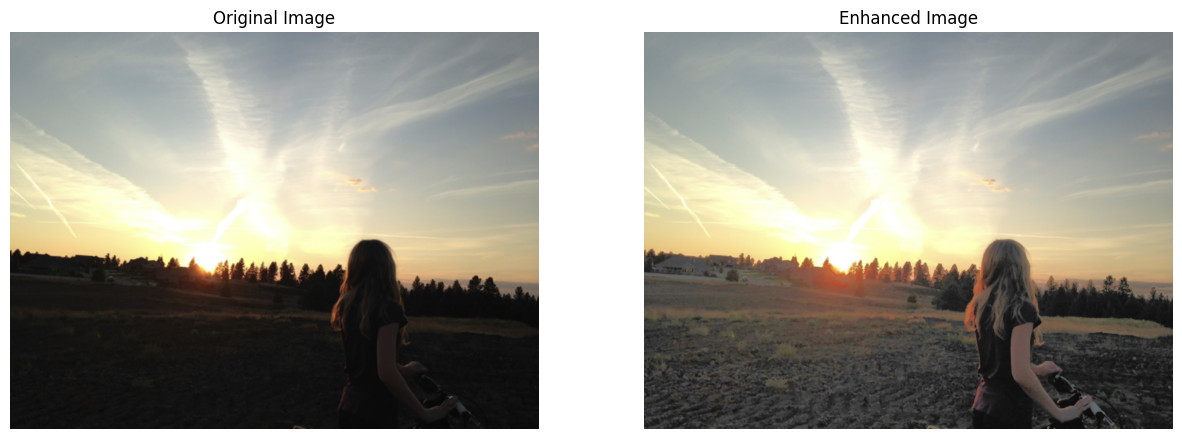

In [ ]:
plt.figure(figsize=(15, 10))
plt.subplot(1,2,1)
plt.imshow(RGB.astype(np.uint8))
plt.title("Original Image")
plt.axis("off")
plt.subplot(1,2,2)
plt.title("Enhanced Image")
plt.imshow(final_image.astype(np.uint8))
plt.axis("off")
plt.show()

In [ ]:
#CLAHE
Input = cv2.imread(input_file, cv2.IMREAD_COLOR)
Input = cv2.cvtColor(Input, cv2.COLOR_BGR2RGB)
clahe = cv2.createCLAHE(clipLimit = 2, tileGridSize = (8,8))
lab = cv2.cvtColor(Input, cv2.COLOR_RGB2LAB)

# Split onto 3 different channels
l, a, b = cv2.split(lab)

# Apply CLAHE to the L-channel
l = clahe.apply(l)

# Merge channels
lab = cv2.merge((l, a, b))

# Convert color space from LAB to RGB
Output = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
Output=cv2.cvtColor(Output, cv2.COLOR_BGR2RGB)

In [ ]:
img_hsv = cv2.cvtColor(Input, cv2.COLOR_RGB2HSV)
img_hsv[:,:,2] = cv2.equalizeHist(img_hsv[:,:,2])
img_he_output = cv2.cvtColor(img_hsv, cv2.COLOR_HSV2RGB)

In [ ]:
import cv2
from skimage import img_as_float64
SIGMA_LIST = [15, 80, 250]
ALPHA = 125.0
BETA = 46.0
G = 5.0
OFFSET = 25.0

def singleScale(img,sigma):
    ssr = np.log10(img) - np.log10(cv2.GaussianBlur(img,(0,0),sigma))
    return ssr

def multiScale(img,sigmas : list):
    retinex = np.zeros_like(img)
    for s in sigmas:
        retinex += singleScale(img, s)

    msr = retinex/len(sigmas)
    return msr

def crf(img, alpha, beta):
    img_sum = np.sum(img,axis=2,keepdims=True)

    color_rest = beta * (np.log10(alpha*img) - np.log10(img_sum))
    return color_rest

#MSRCR
def MSRCR(img, sigmas :list, alpha, beta, G, b):
    img = np.array(img, dtype='uint8')
    height=img.shape[0]
    width=img.shape[1]
    img = cv2.resize(img, (img.shape[1]//2, img.shape[0]//2))
    img = img_as_float64(img)+1

    img_msr = multiScale(img, sigmas)
    img_color = crf(img, alpha, beta)
    img_msrcr = G * (img_msr*img_color + b)


    for i in range(img_msrcr.shape[2]):
        img_msrcr[:, :, i] = (img_msrcr[:, :, i] - np.min(img_msrcr[:, :, i])) / \
                                (np.max(img_msrcr[:, :, i]) - np.min(img_msrcr[:, :, i])) * \
                                255

    img_msrcr = np.uint8(np.minimum(np.maximum(img_msrcr, 0), 255))
    img_msrcr=cv2.resize(img_msrcr, (width,height))
    return img_msrcr


In [ ]:
msrcr_img = MSRCR(RGB,SIGMA_LIST,ALPHA,BETA,G,OFFSET)

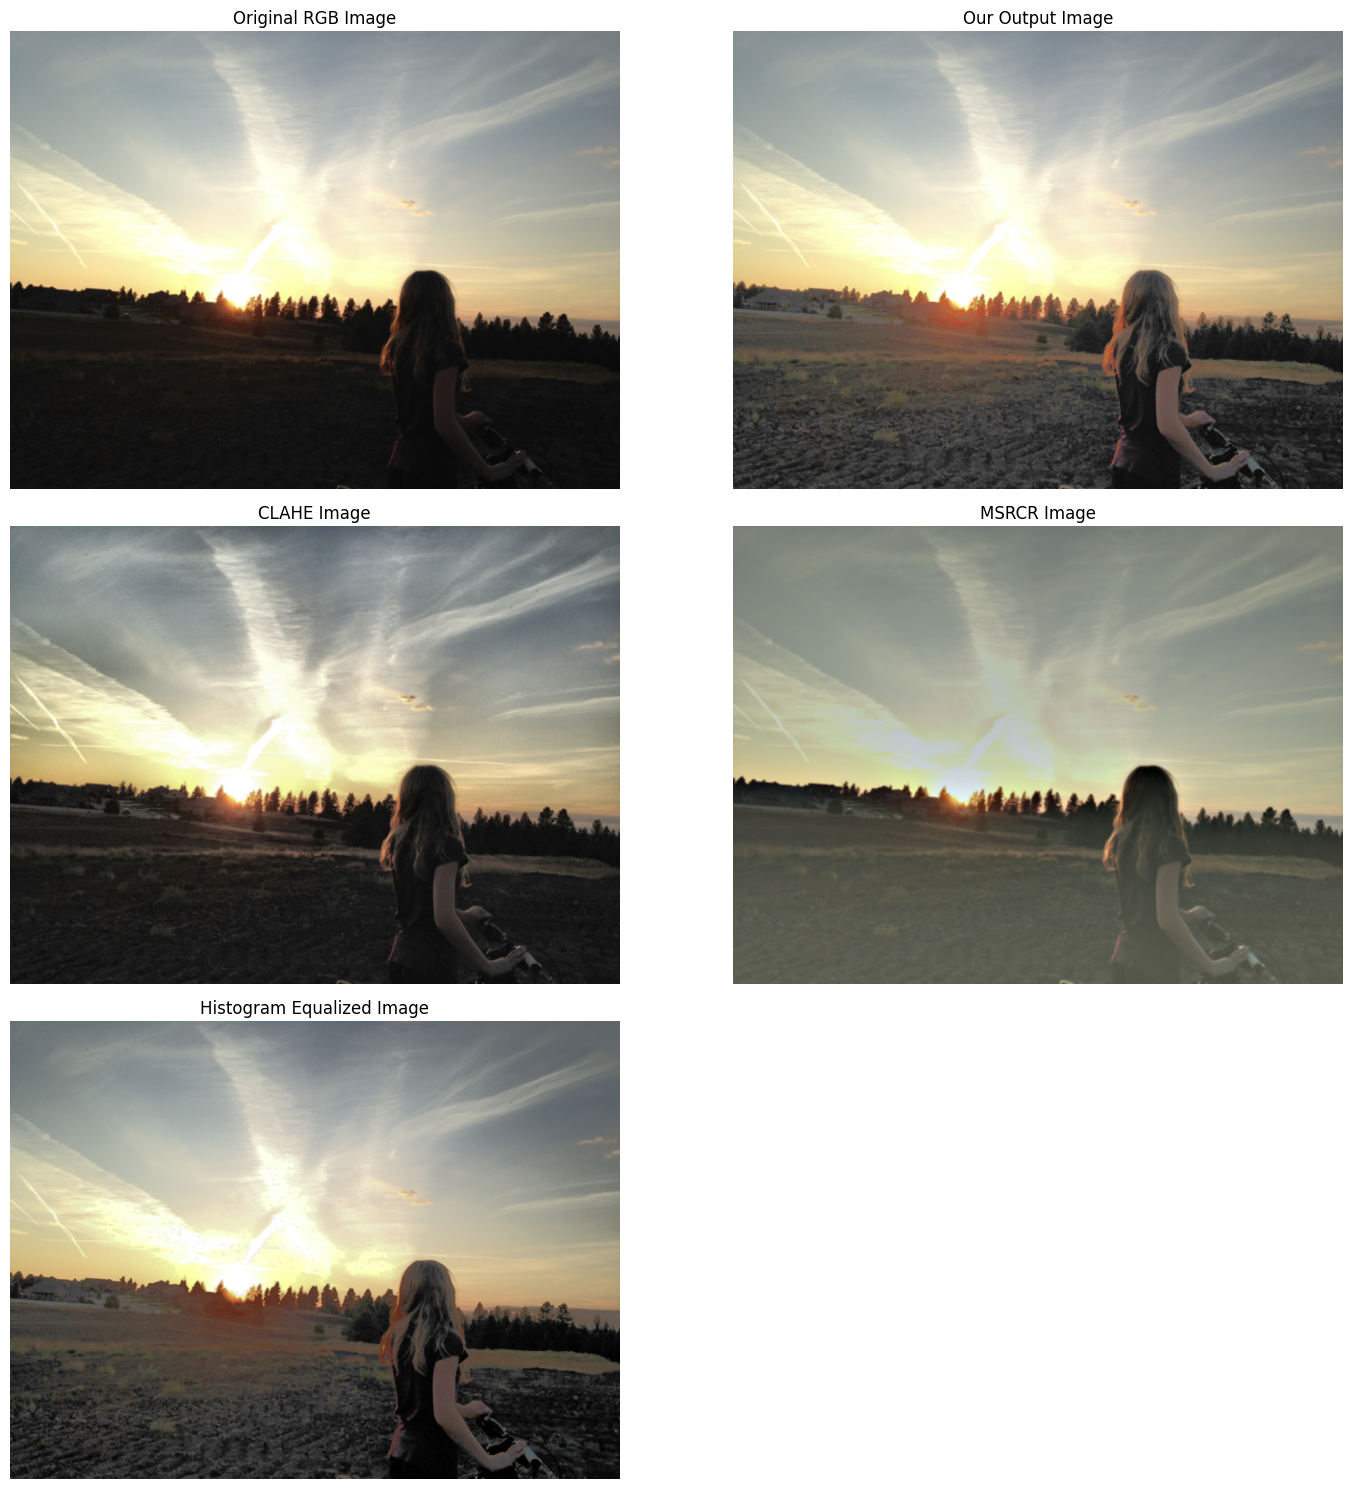

In [ ]:
plt.figure(figsize=(15, 15))
plt.subplot(3, 2, 1)
plt.imshow(RGB)
plt.title("Original RGB Image")
plt.axis("off")

plt.subplot(3, 2, 2)
plt.imshow(final_image)
plt.title("Our Output Image")
plt.axis("off")

plt.subplot(3, 2, 3)
plt.imshow(Output)
plt.title("CLAHE Image")
plt.axis("off")

plt.subplot(3, 2, 4)
plt.imshow(msrcr_img)
plt.title("MSRCR Image")
plt.axis("off")
plt.subplot(3, 2, 5)
plt.imshow(img_he_output)
plt.axis("off")
plt.title("Histogram Equalized Image")
plt.tight_layout()
plt.show()

In [ ]:
import cv2
import numpy as np

def compute_loe(original_img, enhanced_img, resize_shape=(50, 50)):
    # Convert to grayscale if needed
    orig_gs = np.mean(original_img.astype(np.float32), axis=2)
    enh_gs = np.mean(enhanced_img.astype(np.float32), axis=2)
    # if len(original_img.shape) == 3:
    #     original_img = cv2.cvtColor(original_img, cv2.COLOR_RGB2GRAY)
    # if len(enhanced_img.shape) == 3:
    #     enhanced_img = cv2.cvtColor(enhanced_img, cv2.COLOR_BGR2GRAY)

    # Resize to reduce computation
    orig = cv2.resize(orig_gs, resize_shape).astype(np.float32)
    enh = cv2.resize(enh_gs, resize_shape).astype(np.float32)

    N = orig.size
    orig_flat = orig.flatten()
    enh_flat = enh.flatten()

    # Create pairwise comparisons
    diff_orig = np.sign(orig_flat[:, None] - orig_flat[None, :])
    diff_enh = np.sign(enh_flat[:, None] - enh_flat[None, :])

    # Indicator matrix where orders do not match
    mismatch = (diff_orig != diff_enh).astype(np.float32)

    # Sum mismatches and normalize
    loe_value = np.sum(mismatch) / (N * N)
    return loe_value


In [ ]:
import cv2
import numpy as np

def compute_q(image):
    if len(image.shape) == 3:
        image = np.mean(image.astype(np.float32), axis=2)

    image = image.astype(np.uint8)

    # Step 2: Global threshold to split dark and light
    t_global, binary_global = get_threshold_and_binary_weight_map(image)
    dark_pixels = image[binary_global == 1.0]
    light_pixels = image[binary_global == 0.0]
    # Step 3: Q_D — local threshold on dark region
    if len(dark_pixels) > 0:
        t_dark, _ = get_threshold_and_binary_weight_map((dark_pixels).astype(np.uint8))
        a = dark_pixels[dark_pixels < t_dark]
        b = dark_pixels[dark_pixels >= t_dark]
        w1_d = len(a) / len(dark_pixels)
        w2_d = len(b) / len(dark_pixels)
        m1_d = np.mean(a) if len(a) > 0 else 0
        m2_d = np.mean(b) if len(b) > 0 else 0
        Q_D = w1_d * w2_d * (m1_d - m2_d) ** 2
    else:
        Q_D = 0

    # Step 4: Q_L — local threshold on light region
    if len(light_pixels) > 0:
        t_light, _ = get_threshold_and_binary_weight_map((light_pixels).astype(np.uint8))
        a = light_pixels[light_pixels < t_light]
        b = light_pixels[light_pixels >= t_light]
        w1_l = len(a) / len(light_pixels)
        w2_l = len(b) / len(light_pixels)
        m1_l = np.mean(a) if len(a) > 0 else 0
        m2_l = np.mean(b) if len(b) > 0 else 0
        Q_L = w1_l * w2_l * (m1_l - m2_l) ** 2
    else:
        Q_L = 0

    return Q_D, Q_L, t_global




In [ ]:
input_path="/content/drive/MyDrive/Projects/Backlit_Image_Enhancement/img"

In [ ]:
LOE=[] #HE, CLAHE, MSRCR, Ours
QD =[] #Original, HE, CLAHE, MSRCR, Ours
QB= [] #Original, HE, CLAHE, MSRCR, Ours
NIQE=[] #Original, HE, CLAHE, MSRCR, Ours

In [ ]:
for num in tqdm(range (1,5)):
    loe_arr=[0.0,0.0,0.0,0.0] #HE, CLAHE, MSRCR, Ours
    qd_arr =[0.0,0.0,0.0,0.0,0.0] #Original, HE, CLAHE, MSRCR, Ours
    qb_arr = [0.0,0.0,0.0,0.0,0.0] #Original, HE, CLAHE, MSRCR, Ours
    niqe_arr=[0.0,0.0,0.0,0.0,0.0] #Original, HE, CLAHE, MSRCR, Ours
    input_file=input_path+str(num)+".ppm"
    RGB, width, height, max_gray, magic_number = read_ppm(input_file)
    img_grayscale = np.mean(RGB.astype(np.float32), axis=2)
    img_gamma = 255.0 * (img_grayscale / 255.0) ** (1.0 / gamma)
    img_he = image_histogram_equalization(img_grayscale)
    img_alpha_bent = (1.0 - alpha) * img_gamma + alpha * img_he
    threshold, W = get_threshold_and_binary_weight_map(img_grayscale)
    weight_map = get_weight_map(img_grayscale, W, 1)
    final_intensity = weight_map * img_alpha_bent + (1.0 - weight_map) * img_grayscale
    final_intensity /= img_grayscale + parameters["EPSILON"]
    final_image = RGB * np.expand_dims(final_intensity, axis=2)
    final_image=final_image.astype(np.uint8)

    CLAHE_input = cv2.imread(input_file, cv2.IMREAD_COLOR)
    CLAHE_input = cv2.cvtColor(CLAHE_input, cv2.COLOR_BGR2RGB)
    clahe = cv2.createCLAHE(clipLimit = 2, tileGridSize = (8,8))
    lab = cv2.cvtColor(CLAHE_input, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    l = clahe.apply(l)
    lab = cv2.merge((l, a, b))
    Output_clahe = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
    Output_clahe=cv2.cvtColor(Output, cv2.COLOR_BGR2RGB)

    img_hsv = cv2.cvtColor(CLAHE_input, cv2.COLOR_RGB2HSV)
    img_hsv[:,:,2] = cv2.equalizeHist(img_hsv[:,:,2])
    img_he_output = cv2.cvtColor(img_hsv, cv2.COLOR_HSV2RGB)
    msrcr_img = MSRCR(RGB,SIGMA_LIST,ALPHA,BETA,G,OFFSET)
    images=[RGB, img_he_output, Output_clahe, msrcr_img, final_image]
    for i,img in enumerate(images):
        qd,qb,t=compute_q(img)
        niqe_val=niqe(img)
        if (i!=0):
            loe= compute_loe(images[0],img)
            loe_arr[i-1]+=loe
        qd_arr[i]+=qd
        qb_arr[i]+=qb
        niqe_arr[i]+=niqe_val
    LOE.append(loe_arr)
    QD.append(qd_arr)
    QB.append(qb_arr)
    NIQE.append(niqe_arr)


100%|██████████| 4/4 [08:12<00:00, 123.07s/it]


In [ ]:
QD=np.array(QD)
QD

array([[  75.61114515,  664.01810969,  197.0868769 ,  107.45816978,
         522.39941954],
       [ 189.024475  ,  944.32264055,  197.0868769 ,  232.69885898,
         580.06550004],
       [ 201.98990462,  907.13425385,  197.0868769 ,  436.89164687,
         753.64002746],
       [1735.43704467,  922.6632438 ,  197.0868769 ,  168.97228978,
         746.45241851]])

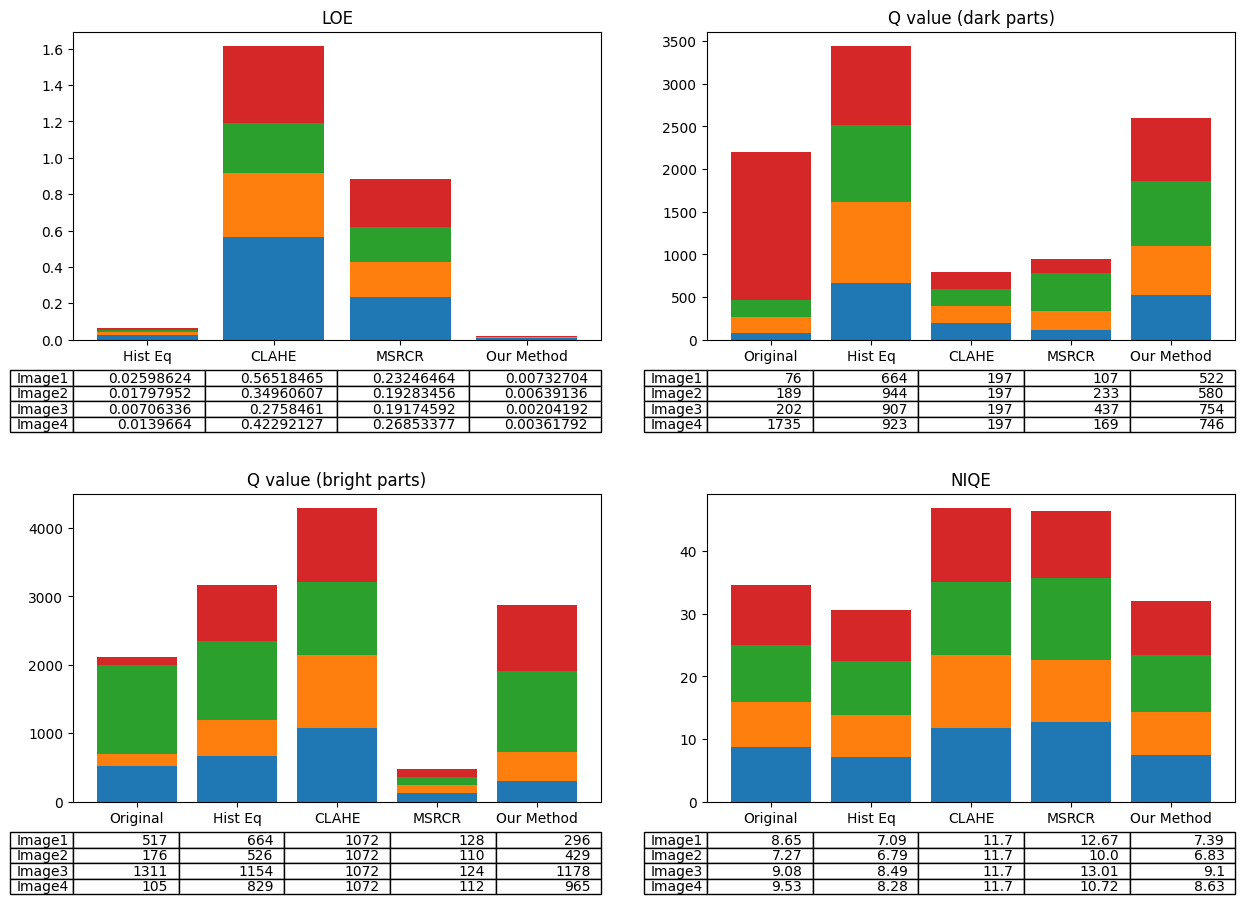

In [ ]:
labels = ['Original', 'Hist Eq', 'CLAHE', 'MSRCR', 'Our Method']
images=['Image1', 'Image2', 'Image3', 'Image4']
plt.figure(figsize=(15,10))
plt.subplot(2,2,1)
y_offset = np.zeros(4)
for row in range(4):
    plt.bar(labels[1:], LOE[row], bottom=y_offset)
    y_offset = y_offset + LOE[row]
plt.table(cellText=LOE,rowLabels=images, loc='bottom', bbox=[0.0, -0.3, 1.0, 0.2])
plt.title("LOE")

plt.subplot(2,2,2)
y_offset = np.zeros(5)
for row in range(4):
    plt.bar(labels, QD[row], bottom=y_offset)
    y_offset = y_offset + QD[row]
plt.table(cellText=np.round(QD).astype(int),rowLabels=images, loc='bottom', bbox=[0.0, -0.3, 1.0, 0.2])
plt.title("Q value (dark parts)")

plt.subplot(2,2,3)
y_offset = np.zeros(5)
for row in range(4):
    plt.bar(labels, QB[row], bottom=y_offset)
    y_offset = y_offset + QB[row]
plt.table(cellText=np.round(QB).astype(int),rowLabels=images, loc='bottom', bbox=[0.0, -0.3, 1.0, 0.2])
plt.title("Q value (bright parts)")

plt.subplot(2,2,4)
y_offset = np.zeros(5)
for row in range(4):
    plt.bar(labels, NIQE[row], bottom=y_offset)
    y_offset = y_offset + NIQE[row]
plt.table(cellText=np.round(NIQE,decimals=2),rowLabels=images, loc='bottom', bbox=[0.0, -0.3, 1.0, 0.2])
plt.title("NIQE")
plt.subplots_adjust(hspace=0.5)
plt.show()